In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
image_size = 128
latent_size = 120
batch_size = 128
epochs = 25
lr = 0.0002

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        layers.Conv2D(1, (4, 4), padding='valid', use_bias=False),
        layers.Flatten(),
        layers.Activation('sigmoid')
    ])
    return model

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(latent_size,)),
        layers.Reshape((1, 1, latent_size)),
        
        layers.Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False),
        layers.Activation('tanh')
    ])
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.5)

In [ ]:
def train_step(images):
    noise = tf.random.normal([batch_size, latent_size])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    #return print((gen_loss.numpy()[0], disc_loss.numpy()[0]))

train_gen=ImageDataGenerator(rescale=1/255.)
train_dataset = train_gen.flow_from_directory(
    '/kaggle/input/100-bird-species/train', 
    target_size=(120,120), 
    batch_size=batch_size, 
    class_mode=None
)

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/100-bird-species/train', 
    image_size=(128, 128), 
    batch_size=batch_size, 
    label_mode=None
)
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

Found 84635 files belonging to 1 classes.


In [8]:
#discriminator = build_discriminator()
#generator = build_generator()

discriminator=tf.keras.models.load_model('/kaggle/input/mmmooo/discriminatorNew.keras')
generator=tf.keras.models.load_model('/kaggle/input/mmmooo/generatorNew.keras')

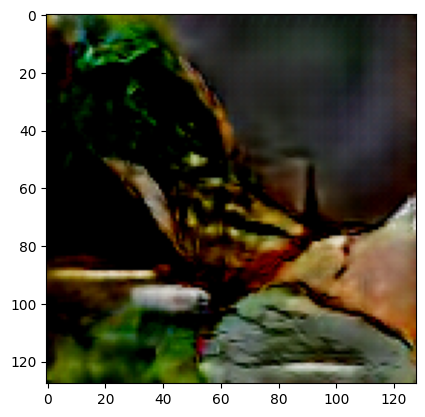

In [21]:
noise=tf.random.normal([1,120])
img=generator(noise)
plt.imshow(img[0,:,:,:])
plt.show()

In [ ]:
#discriminator(img)#.layers[-1].output#(img)

In [ ]:
#aa=0
for epoch in range(70):
    #aa=0
    for image_batch in train_dataset:
        train_step(image_batch)
        #print(aa)
        #aa+=1
    #print(aa)
    #aa+=1

In [ ]:
generator.save('/kaggle/working/generatorNew.keras')
discriminator.save('/kaggle/working/discriminatorNew.keras')



In [ ]:
#!zip -r 'generator.zip' '/kaggle/working/generator'
#!zip -r 'discriminator.zip' '/kaggle/working/discriminator'